# Generate Crime Hotspot Visualisation

In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from datetime import datetime
import folium
from folium.plugins import HeatMap

# Load data
df = pd.read_csv('NYPD_Complaint_Data_YTD.csv')
# Convert dates and times
df['cmplnt_fr_dt'] = pd.to_datetime(df['cmplnt_fr_dt'])
df['cmplnt_fr_tm'] = pd.to_datetime(df['cmplnt_fr_tm'], format='%H:%M:%S').dt.time
df['hour'] = df['cmplnt_fr_tm'].apply(lambda x: x.hour)
df['day_of_week'] = df['cmplnt_fr_dt'].dt.dayofweek
df['month'] = df['cmplnt_fr_dt'].dt.month

# Spatial clustering for hotspots
coords = df[['latitude', 'longitude']].dropna().values
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian  # 0.5km radius

db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
df['cluster'] = db.labels_

# Filter hotspot clusters (excluding noise points labeled -1)
hotspots = df[df['cluster'] != -1].groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'cmplnt_num': 'count',
    'ofns_desc': lambda x: x.mode()[0],
    'law_cat_cd': lambda x: x.mode()[0]
}).rename(columns={'cmplnt_num': 'crime_count'})

# Visualize hotspots
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
HeatMap(data=df[['latitude', 'longitude']].dropna().values.tolist(), radius=15).add_to(m)
m.save('crime_hotspots.html')

# Temporal Analysis

In [11]:
# Temporal patterns in hotspots
hotspot_df = df[df['cluster'] != -1].copy()

# Hourly patterns
hourly_patterns = hotspot_df.groupby(['cluster', 'hour']).size().unstack().fillna(0)

# Weekly patterns
weekly_patterns = hotspot_df.groupby(['cluster', 'day_of_week']).size().unstack().fillna(0)

# Seasonal patterns
monthly_patterns = hotspot_df.groupby(['cluster', 'month']).size().unstack().fillna(0)

# Victim demographic analysis

In [12]:
# Analyze victim demographics in hotspots
victim_patterns = hotspot_df.groupby(['cluster', 'vic_age_group', 'vic_race', 'vic_sex']).agg({
    'cmplnt_num': 'count',
    'ofns_desc': lambda x: x.value_counts().index[0]
}).rename(columns={'cmplnt_num': 'count', 'ofns_desc': 'most_common_offense'})

# Example: Elderly victim analysis
elderly_crimes = hotspot_df[hotspot_df['vic_age_group'] == '65+'].groupby('cluster').agg({
    'cmplnt_num': 'count',
    'ofns_desc': lambda x: x.mode()[0],
    'prem_typ_desc': lambda x: x.mode()[0]
})

# Female victim analysis
female_crimes = hotspot_df[hotspot_df['vic_sex'] == 'F'].groupby('cluster').agg({
    'cmplnt_num': 'count',
    'ofns_desc': lambda x: x.mode()[0],
    'hour': lambda x: x.mode()[0]
})

# Establishments near  hotspots analysis

In [13]:
from geopy.distance import great_circle
import overpy
import pandas as pd
import time

api = overpy.Overpass()

def get_nearby_amenities(lat, lon, radius=100):
    query = f"""
    [out:json];
    (
      node(around:{radius},{lat},{lon})["amenity"];
      way(around:{radius},{lat},{lon})["amenity"];
      relation(around:{radius},{lat},{lon})["amenity"];
    );
    out center;
    """
    try:
        result = api.query(query)
        amenities = []
        for node in result.nodes + result.ways + result.relations:
            # Only add if it has both amenity type and coordinates
            if hasattr(node, 'tags') and 'amenity' in node.tags and hasattr(node, 'lat') and hasattr(node, 'lon'):
                amenities.append({
                    'type': node.tags.get('amenity', 'unknown'),
                    'name': node.tags.get('name', 'unknown'),
                    'lat': float(node.lat),
                    'lon': float(node.lon)
                })
        return amenities
    except Exception as e:
        print(f"Error fetching amenities: {e}")
        return []

# Analyze amenities in top hotspots
top_hotspots = hotspots.nlargest(10, 'crime_count')
amenity_analysis = []

for _, row in top_hotspots.iterrows():
    amenities = get_nearby_amenities(row['latitude'], row['longitude'], 200)
    
    # Only proceed if we got amenities
    if amenities:
        amenity_df = pd.DataFrame(amenities)
        amenity_counts = amenity_df['type'].value_counts()
        amenity_analysis.append({
            'cluster': row.name,
            'crime_count': row['crime_count'],
            'top_amenities': amenity_counts.to_dict()
        })
    else:
        amenity_analysis.append({
            'cluster': row.name,
            'crime_count': row['crime_count'],
            'top_amenities': {}  # Empty dict if no amenities found
        })
    
    time.sleep(1)  # Respect API rate limits

In [18]:
(amenity_analysis)

[{'cluster': 1,
  'crime_count': 15699,
  'top_amenities': {'bicycle_parking': 3,
   'drinking_water': 2,
   'fire_station': 1}},
 {'cluster': 0,
  'crime_count': 15658,
  'top_amenities': {'school': 1, 'drinking_water': 1, 'bicycle_parking': 1}},
 {'cluster': 3, 'crime_count': 477, 'top_amenities': {'school': 1}},
 {'cluster': 2,
  'crime_count': 381,
  'top_amenities': {'bicycle_repair_station': 1, 'bicycle_parking': 1}},
 {'cluster': 5,
  'crime_count': 361,
  'top_amenities': {'cafe': 1,
   'bar': 1,
   'restaurant': 1,
   'place_of_worship': 1,
   'parking': 1,
   'studio': 1}},
 {'cluster': 6,
  'crime_count': 158,
  'top_amenities': {'fast_food': 2,
   'childcare': 2,
   'ice_cream': 1,
   'restaurant': 1}},
 {'cluster': 7,
  'crime_count': 77,
  'top_amenities': {'waste_basket': 15,
   'bench': 14,
   'recycling': 5,
   'hand_sanitizing': 2,
   'vending_machine': 2,
   'fast_food': 1,
   'bureau_de_change': 1,
   'stroller_rental': 1,
   'loading_dock': 1}},
 {'cluster': 15, 'c

In [22]:
import json

# Your JSON data

# Convert to a clean string for the prompt
data_str = json.dumps(amenity_analysis, indent=2)

prompt = f"""
Analyze these crime clusters and nearby amenities to identify potential patterns and reasons for criminal activity.
For each cluster, consider:
1. The types of amenities present
2. Possible human activity patterns they attract
3. Known criminological theories about such locations
4. Temporal factors (if time data were available)

Data:
{data_str}

Provide insights in this format for each significant cluster:

Cluster [ID] - [Total Crimes] crimes
Main Amenities: [List]
Potential Factors:
- Factor 1: [Explanation]
- Factor 2: [Explanation]
- Factor 3: [Explanation]
Crime Prevention Suggestions:
- Suggestion 1
- Suggestion 2

Then provide 3 overall conclusions about the dataset.
"""

system_prompt= f"""
You are a senior criminology analyst with expertise in urban crime patterns and environmental design. Your task is to:

1. Analyze crime clusters with their nearby amenities
2. Identify plausible explanations for crime patterns using:
   - Routine Activity Theory (motivated offenders + suitable targets + lack of guardianship)
   - Crime Prevention Through Environmental Design (CPTED) principles
   - Known New York City crime trends
3. Provide actionable recommendations
4. Use this format for each significant cluster:

---
**Cluster [ID]** | [Total Crimes] crimes  
**Key Amenities**: [List]  
**Primary Crime Drivers**:  
- Driver 1: [Explanation linking amenities to crime]  
- Driver 2: [Additional factor]  
**Prevention Strategies**:  
- [Evidence-based suggestion]  
- [Urban design/policing tactic]  
---

For the final summary, highlight:  
1. Top 3 cross-cluster patterns  
2. Highest-risk amenity types  
3. One city-wide policy recommendation  
"""

In [27]:
import ollama

response = ollama.chat(model="llama3:latest", messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ])
analysis_content = response["message"].get("content", "")
print(analysis_content)

Here are the insights for each significant cluster:

**Cluster 0 - 15658 crimes**
Main Amenities: school, drinking water, bicycle parking
Potential Factors:
- Factor 1: School's presence attracts both students and staff, potentially increasing foot traffic and criminal opportunities. 
- Factor 2: Drinking water and bicycle parking amenities may not be directly related to crime, but could indicate a higher level of activity in the area.
Crime Prevention Suggestions:
- Increase police patrols around school hours
- Implement CCTV cameras in high-crime areas

**Cluster 1 - 15699 crimes**
Main Amenities: bicycle parking, drinking water, fire station
Potential Factors:
- Factor 1: Bicycle parking and drinking water amenities may indicate a higher level of human activity, increasing opportunities for crime.
- Factor 2: Fire station's presence could lead to increased emergency response times, potentially reducing criminal opportunity windows.
Crime Prevention Suggestions:
- Install improved li

In [28]:

# Write to file (creates new file or overwrites existing)
with open('inferences.txt', 'w') as file:
    file.write(analysis_content)

In [29]:
prompt2=f"""
Based on the data from your previous response : 
{analysis_content},
give predictions for future crimes and other relevant issues
"""
response = ollama.chat(model="llama3:latest", messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt2}
    ])
prediction_content = response["message"].get("content", "")
with open('predictions.txt', 'w') as file:
    file.write(prediction_content)


# Pattern Matching and Correlation Analysis

In [14]:
from scipy.stats import chi2_contingency

# Example: Correlation between elderly victims and retirement homes
elderly_hotspots = elderly_crimes.nlargest(5, 'cmplnt_num')
retirement_home_correlation = []

for cluster in elderly_hotspots.index:
    amenities = get_nearby_amenities(
        hotspots.loc[cluster, 'latitude'],
        hotspots.loc[cluster, 'longitude'],
        200
    )
    has_retirement_home = any(a['type'] in ['nursing_home', 'retirement_home'] for a in amenities)
    retirement_home_correlation.append(has_retirement_home)

# Create contingency table
contingency = pd.crosstab(
    pd.Series(retirement_home_correlation, name='has_retirement_home'),
    pd.Series(elderly_hotspots['cmplnt_num'] > elderly_hotspots['cmplnt_num'].median(), name='high_elderly_crime')
)

chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square test p-value: {p:.4f}")

Chi-square test p-value: 1.0000


# Viz and Reporting

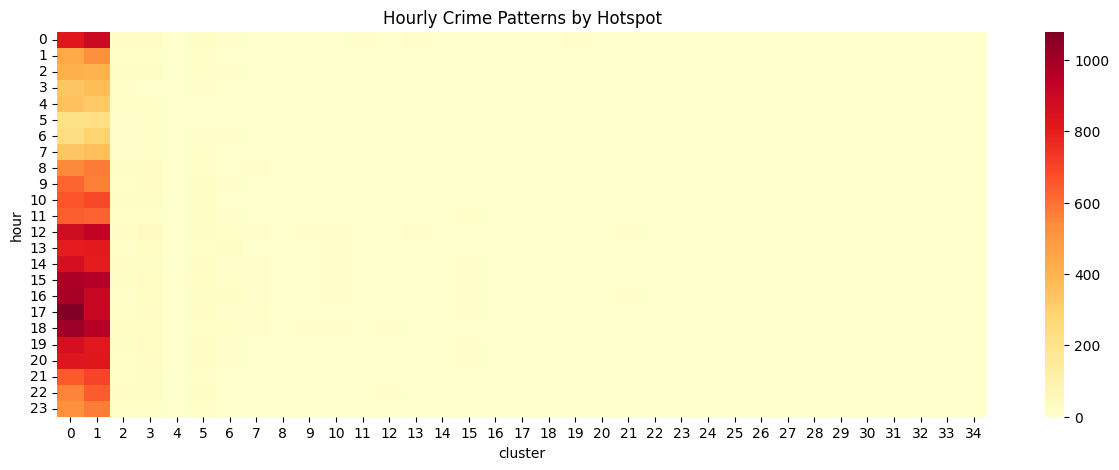

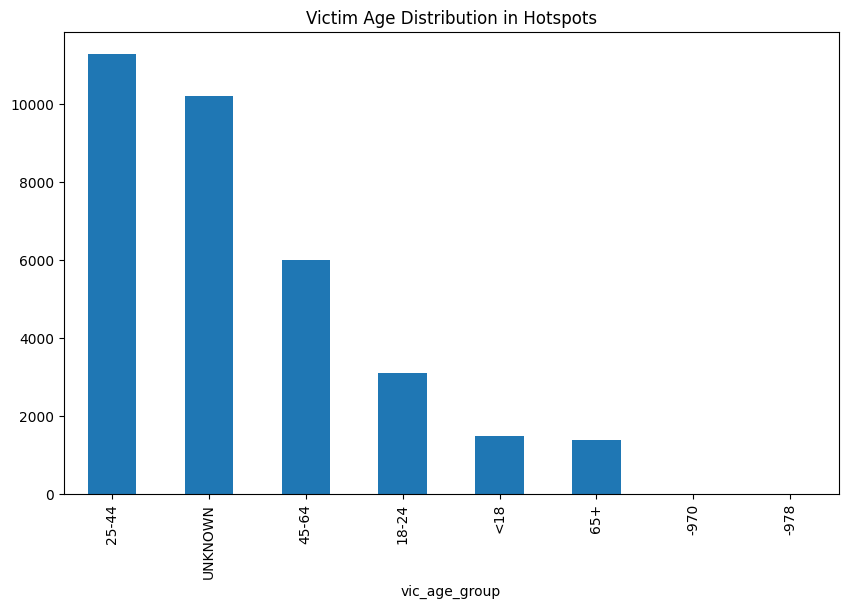

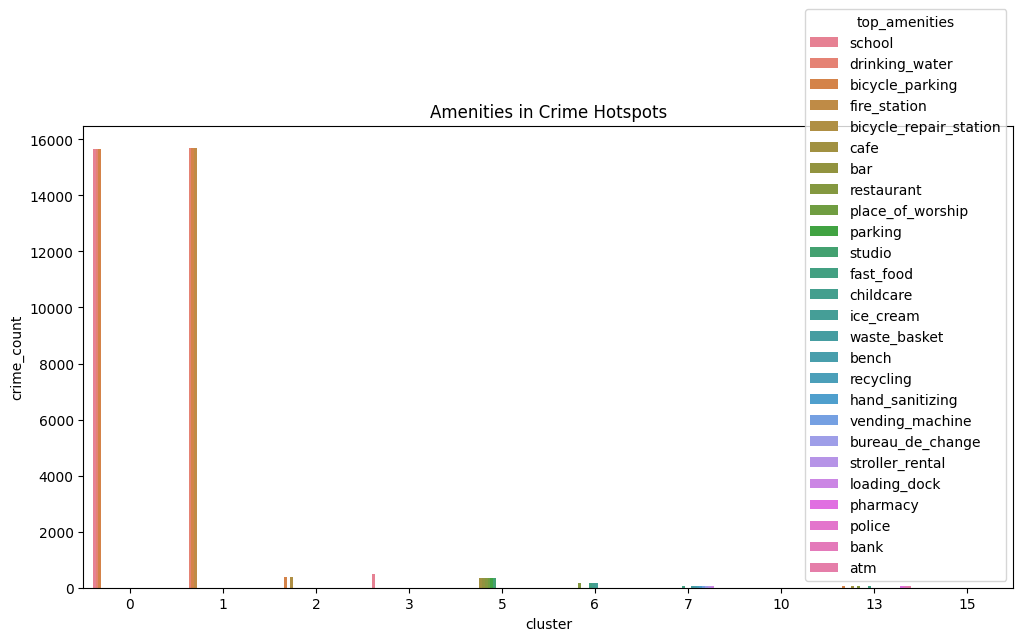

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot temporal patterns
plt.figure(figsize=(15, 5))
sns.heatmap(hourly_patterns.T, cmap='YlOrRd')
plt.title('Hourly Crime Patterns by Hotspot')
plt.savefig('hourly_patterns.png')

# Plot victim demographics
plt.figure(figsize=(10, 6))
hotspot_df['vic_age_group'].value_counts().plot(kind='bar')
plt.title('Victim Age Distribution in Hotspots')
plt.savefig('victim_age.png')

# Plot amenity correlations
amenity_df = pd.DataFrame(amenity_analysis)
plt.figure(figsize=(12, 6))
sns.barplot(data=amenity_df.explode('top_amenities'), x='cluster', y='crime_count', hue='top_amenities')
plt.title('Amenities in Crime Hotspots')
plt.savefig('amenity_correlation.png')

In [ ]:
from multiprocessing import Pool

def process_hotspot(cluster_data):
    # Your analysis for each hotspot
    pass

with Pool(4) as p:  # Use 4 cores
    results = p.map(process_hotspot, hotspot_data)

In [ ]:
import json

# Save intermediate results
with open('intermediate_results.json', 'w') as f:
    json.dump(amenity_analysis, f)  